Importing Libraries

In [1]:
import torch
import numpy as np
from torchvision import transforms
import torchvision.models as  models
from torch.utils.data import DataLoader
from src.dataset import PascalVOC_Dataset
import torch.optim as optim
from src.utils import encode_labels, plot_history
import os
import torch.utils.model_zoo as model_zoo
import src.utils as utils 
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm
import gc
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import cv2

Importing Model Inception-V3

In [3]:
model = models.inception_v3(pretrained=True)
model

d:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Applying Transformations and loading dataset in dataloaders

In [7]:
mean=[0.457342265910642, 0.4387686270106377, 0.4073427106250871]
std=[0.26753769276329037, 0.2638145880487105, 0.2776826934044154]
    
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
    
transformations = transforms.Compose([transforms.Resize((299, 299)),
#                                      transforms.RandomChoice([
#                                              transforms.CenterCrop(300),
#                                              transforms.RandomResizedCrop(300, scale=(0.80, 1.0)),
#                                              ]),                                      
                                      transforms.RandomChoice([
                                          transforms.ColorJitter(brightness=(0.80, 1.20)),
                                          transforms.RandomGrayscale(p = 0.25)
                                          ]),
                                      transforms.RandomHorizontalFlip(p = 0.25),
                                      transforms.RandomRotation(25),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean = mean, std = std),
                                      ])
        
transformations_valid = transforms.Compose([transforms.Resize((299,299)), 
                                          transforms.ToTensor(), 
                                           transforms.Normalize(mean = mean, std = std),
                                          ])
data_dir='./VOCdevkit-1'
# Create train dataloader
data_dir='./VOCdevkit-1'
# Create train dataloader
dataset_train = PascalVOC_Dataset(data_dir,
                                      year='2007', 
                                      image_set='train', 
                                      download=False, 
                                      transform=transformations, 
                                      target_transform=encode_labels)
    
train_loader = DataLoader(dataset_train, batch_size=16, num_workers=0, shuffle=True)
dataset_valid = PascalVOC_Dataset(data_dir,
                                      year='2007', 
                                      image_set='val', 
                                      download=False, 
                                      transform=transformations_valid, 
                                      target_transform=encode_labels)
    
valid_loader = DataLoader(dataset_valid, batch_size=16, num_workers=0)

Modifying Last Layers for Transfer Learning

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for param in model.parameters():
    param.requires_grad = False   

model.aux_logits = False
num_ftrs = model.fc.in_features
model.fc=nn.Sequential(
    nn.Linear(num_ftrs,128),
    nn.ReLU(inplace=True),
    nn.Linear(128,20)
)
model.to(device)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Defining Criterion and Optimizers for the Inception-V3

In [13]:
criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

Defining Function to get Average Precison,Accuracy and Loss for Each epoch

In [ ]:
def train_model(model, device,criterion, optimizer, train_loader, valid_loader, epochs):
 
    
    # Each epoch has a training and validation phase
    for epoch in range(epochs):
        print("-------Epoch {}----------".format(epoch+1))
        running_correct=0.0
        running_loss=0.0
        for phase in ['train', 'valid']:
            running_loss = 0.0
            running_correct=0.0
            
            
            
            if phase == 'train':
                model.train(True)  # Set model to training mode
                
                for idx,(data, target) in enumerate(train_loader):
                    
                    
                    
                    
                    data, target = data.to(device), target.to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    
                    output = model(data)
                    
                    outputs=torch.nn.functional.softmax(output,1).cpu()
                    
                    
                    outputs[outputs >= 0.5] = 1
                    correct = (outputs == target).sum()
                    running_correct+=correct
                    


                    
                    loss = criterion(output, target)
                    
                    # Get metrics here
                    running_loss += loss # sum up batch loss
                    
                     
                    # Backpropagate the system the determine the gradients
                    loss.backward()
                    
                    # Update the paramteres of the model
                    optimizer.step()
            
                    # clear variables
                    del data, target, output
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                    #print("loss = ", running_loss)
                    
                num_samples = float(len(train_loader.dataset))
                tr_loss_ = running_loss.item()/num_samples
                tr_accuracy = running_correct.item()/num_samples
                
                print('train_loss: {:.4f}, train_accuracy:{:.3f}'.format(
                    tr_loss_, tr_accuracy))
                
                
                        
                        
            else:
                model.train(False)  # Set model to evaluate mode
    
                # torch.no_grad is for memory savings
                with torch.no_grad():
                    for idx,(data, target) in enumerate(valid_loader):
                        
                        data, target = data.to(device), target.to(device)
                        output = model(data)
                        
                        loss = criterion(output, target)
                        outputs=torch.nn.functional.softmax(output,1).cpu()
                  
                        outputs[outputs >= 0.5] = 1
                        correct = (outputs == target).sum()
                        running_correct+=correct
                        running_loss += loss # sum up batch loss
                        
                        del data, target, output
                        gc.collect()
                        torch.cuda.empty_cache()

                    num_samples = float(len(valid_loader.dataset))
                    val_loss_ = running_loss.item()/num_samples
                    val_accuracy = running_correct.item()/num_samples
                    
                    
                
                    print('val_loss: {:.4f}, val_accuracy:{:.3f}'.format(
                    val_loss_, val_accuracy))
    return model                
                    
                    
  


Training the Model

In [15]:
model_trained = train_model(model,device,criterion, optimizer,train_loader,valid_loader,10)


-------Epoch 1----------
train_loss: 0.1977, train_accuracy:0.130
val_loss: 0.1467, val_accuracy:0.295
-------Epoch 2----------
train_loss: 0.1463, train_accuracy:0.389
val_loss: 0.1249, val_accuracy:0.455
-------Epoch 3----------
train_loss: 0.1379, train_accuracy:0.462
val_loss: 0.1173, val_accuracy:0.497
-------Epoch 4----------
train_loss: 0.1341, train_accuracy:0.503
val_loss: 0.1111, val_accuracy:0.525
-------Epoch 5----------
train_loss: 0.1292, train_accuracy:0.529
val_loss: 0.1118, val_accuracy:0.537
-------Epoch 6----------
train_loss: 0.1274, train_accuracy:0.529
val_loss: 0.1094, val_accuracy:0.605
-------Epoch 7----------
train_loss: 0.1249, train_accuracy:0.546
val_loss: 0.1064, val_accuracy:0.657
-------Epoch 8----------
train_loss: 0.1248, train_accuracy:0.537
val_loss: 0.1071, val_accuracy:0.625
-------Epoch 9----------
train_loss: 0.1252, train_accuracy:0.567
val_loss: 0.1050, val_accuracy:0.639
-------Epoch 10----------
train_loss: 0.1237, train_accuracy:0.552
val_lo

Saving the trained Model 

In [6]:
torch.save(model_trained.state_dict(), 'models/Inception_V3.h5')

NameError: name 'model_trained' is not defined

Loading the save model

In [9]:
model = models.inception_v3(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   

model.aux_logits = False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Sequential(
    nn.Linear(num_ftrs,128),
    nn.ReLU(inplace=True),
    nn.Linear(128,20)
)
model.load_state_dict(torch.load('models/Inception_V3.h5'))


<All keys matched successfully>

Reading Validation File 

In [10]:
file_names_list=0
dir='VOCdevkit-1/VOCdevkit/VOC2007/ImageSets/Main/'
image_dir='VOCdevkit-1/VOCdevkit/VOC2007/JPEGImages/'
for file in os.listdir(dir):
    if(file == f"val.txt"):
        #file_path=os.path.join(dir,"")
        file_obj=open(os.path.join(dir,f"{file}"),"r")
        file_names=file_obj.read()
        file_name_list=file_names.splitlines()

Saving images in Dictionary 

In [11]:
img_dict={}
file_name_list
img_path_list=[]
for index in range(0,len(file_name_list)):
    file_name=file_name_list[index]
    complete_file_name=os.path.join(image_dir,f"{file_name}.jpg")
    img_path_list.append(complete_file_name)
    img_dict[index]=complete_file_name


Creating Validation Batch by staking validation images

In [12]:
img_list=[Image.open(img_path) for img_path in img_path_list]

validation_batch=torch.stack([transformations_valid(img).to(device) for img in img_list] )


Defining Split Into Batches Function

In [13]:
def splitIntoBatches(total_size,batch_size):
    if(total_size%batch_size==0):
        split =int(total_size/batch_size)
        return [batch_size*(i+1) for i in range(0,split)]
    else:
        list=[]
        split=int(total_size/batch_size)
        for i in range(0,split):
            list.append(batch_size*(i+1))
        list.append((split*(batch_size))+(total_size%batch_size))
        return list

Spiting the validation batch and getting probabilities for the validation batch

In [14]:
from collections import defaultdict
model.train(False)
label_probs=defaultdict(list)
prob_list=[]
pred_probs=[]
prev=0
counter=0

for batch_split in splitIntoBatches(len(validation_batch),100):
    pred_logits_tensor=model(validation_batch[prev:batch_split])
    pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
    

    for probs in pred_probs:
        for i in range(0,20):
            label_probs[i].append((probs[i],counter))
            prob_list.append(probs)
        counter=counter+1    
           
       
       
       
    prev=batch_split



Getting Top 10 Probability for Each class

In [15]:
print(len(label_probs[2]))
top_10=defaultdict(list)

for label in label_probs:
    label_probs[label].sort(key=lambda i:i[0],reverse=True)
# prob_list.sort(key = lambda i:i[0], reverse = True)
for class_no  in range(0,20):
    for index in range(0,10):
        top_10[class_no].append((label_probs[class_no][index][0],img_dict[label_probs[class_no][index][1]]))

2510


Visualizing the top 10 predictions of each class with probabilities of each

10


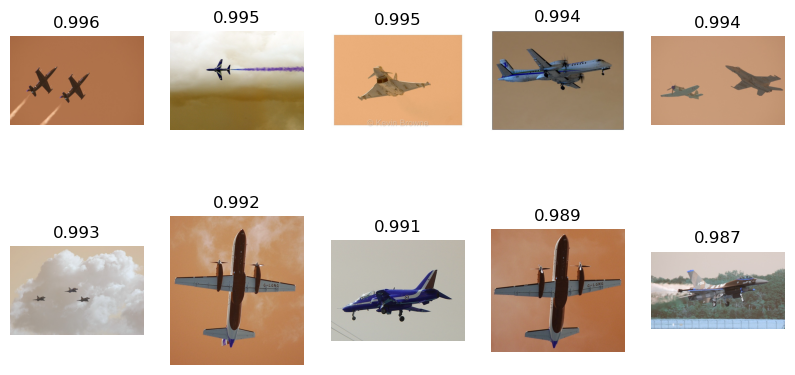

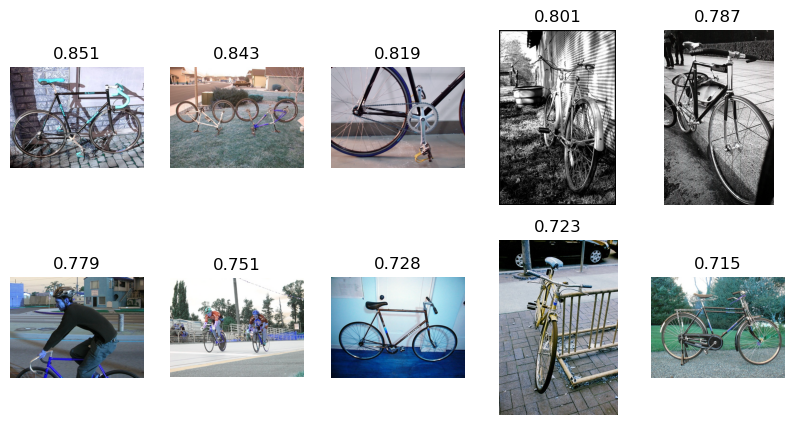

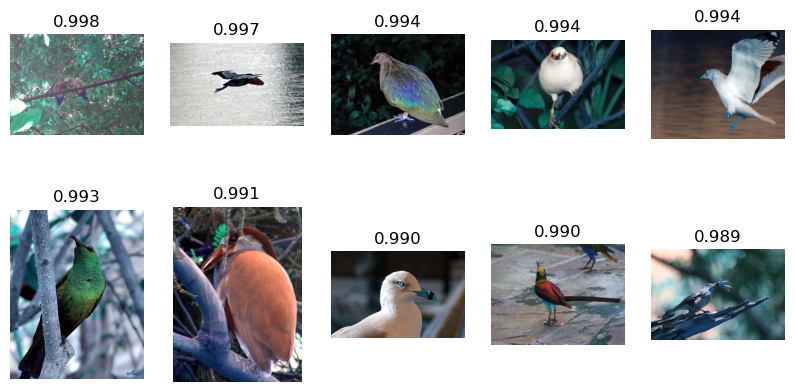

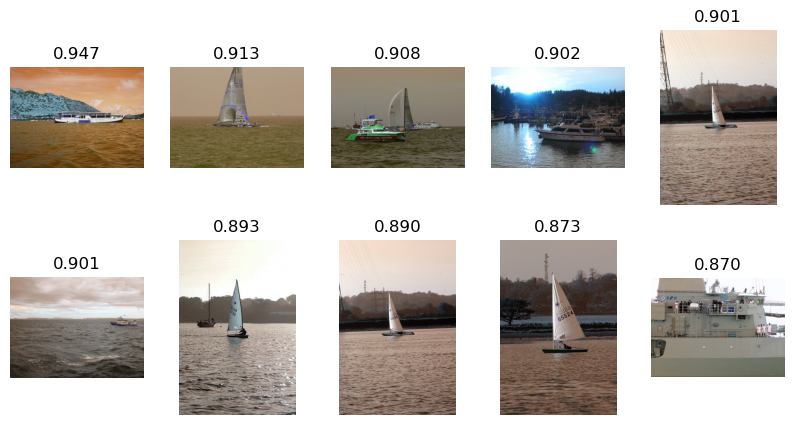

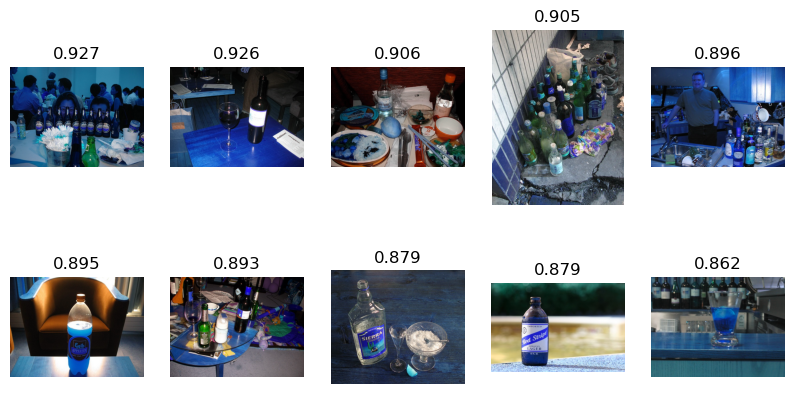

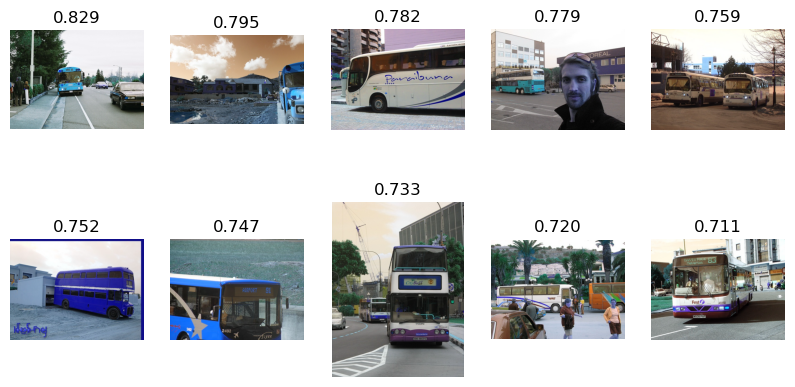

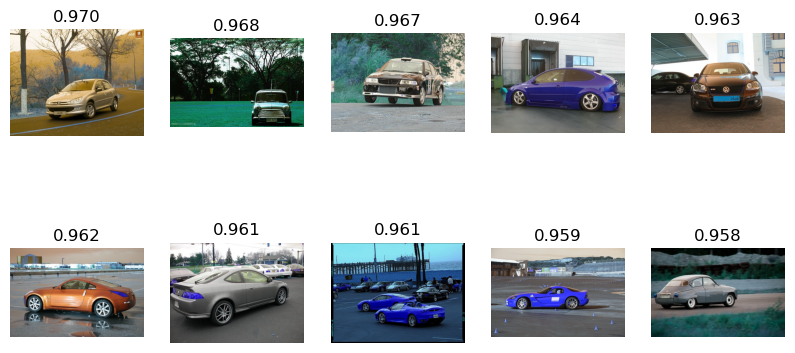

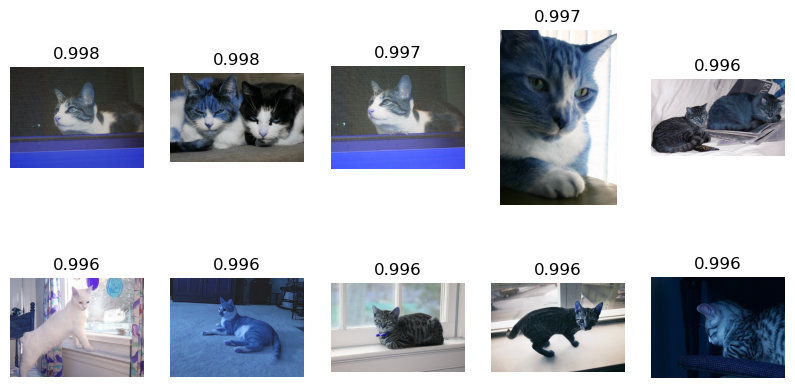

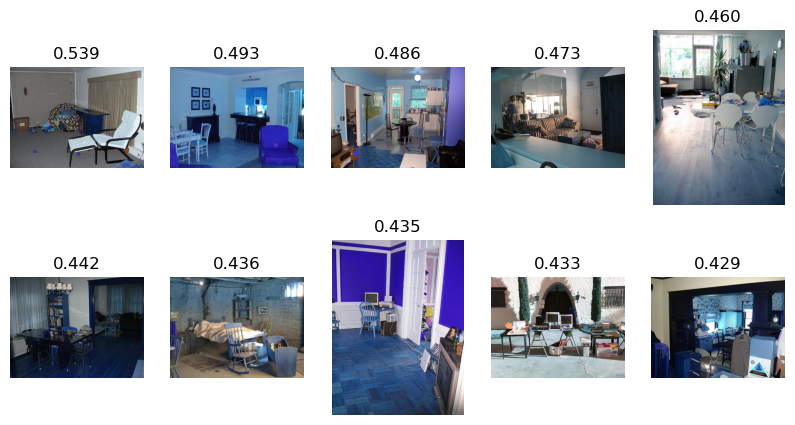

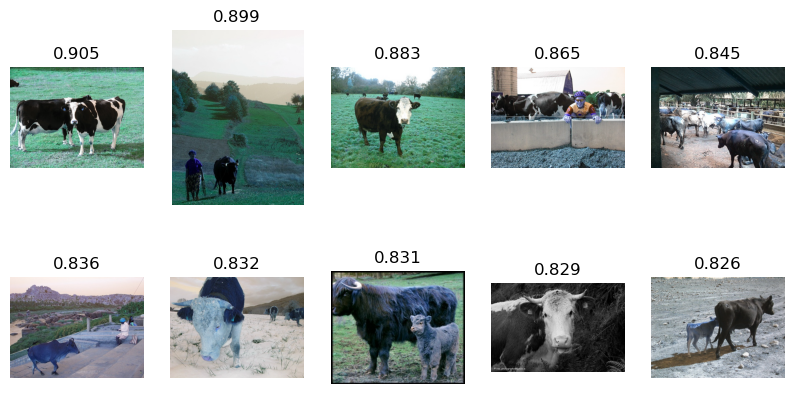

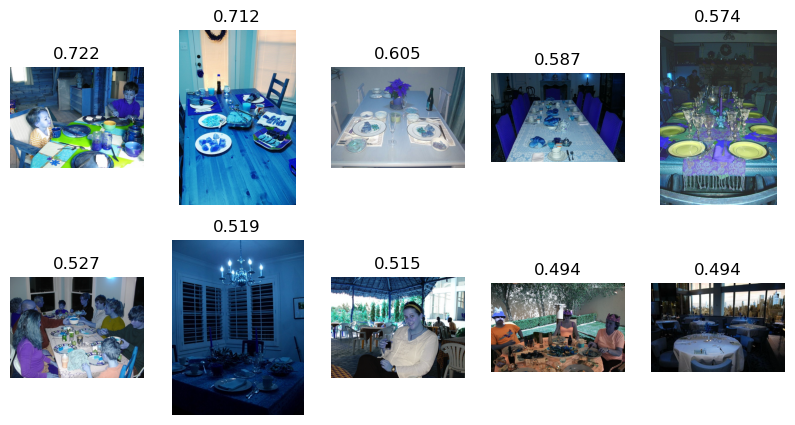

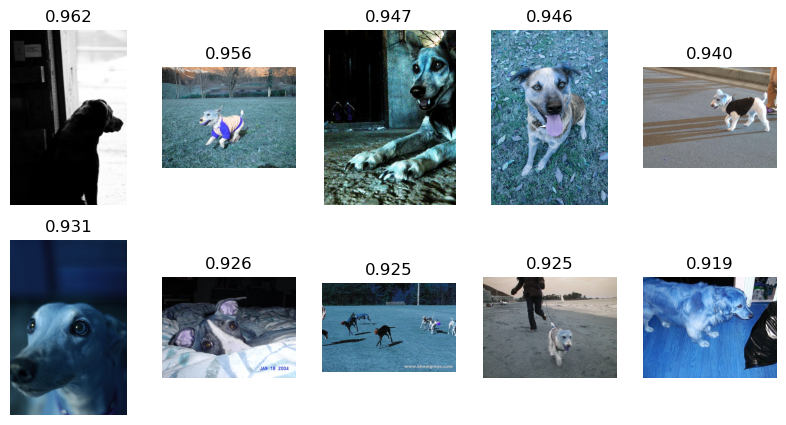

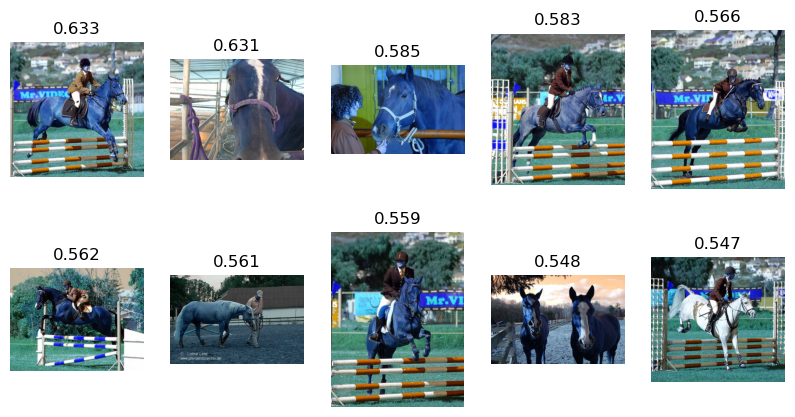

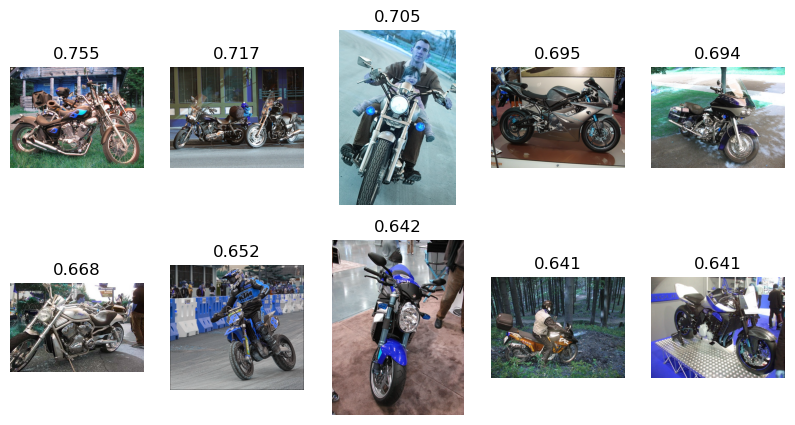

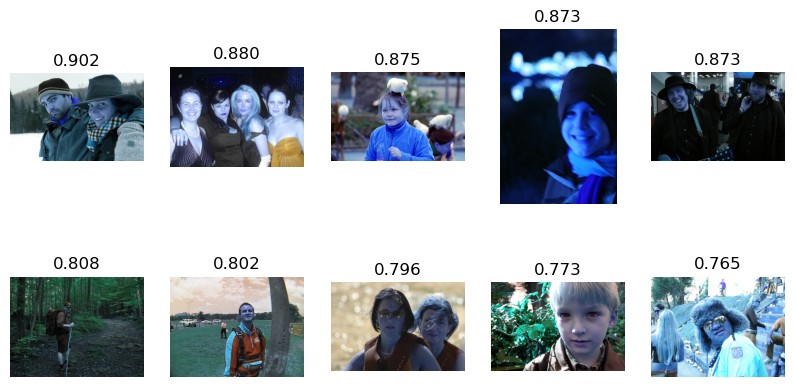

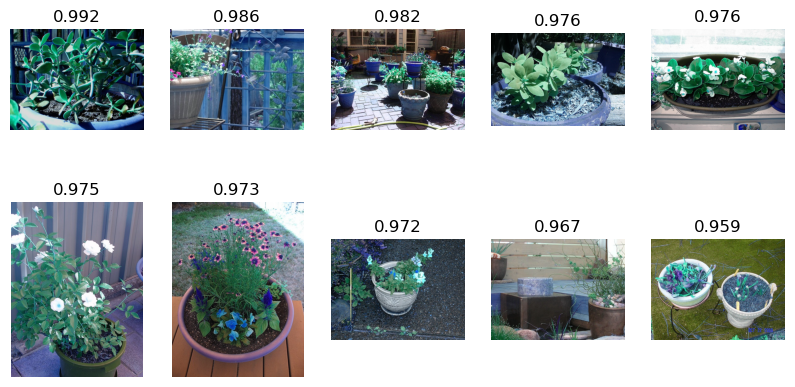

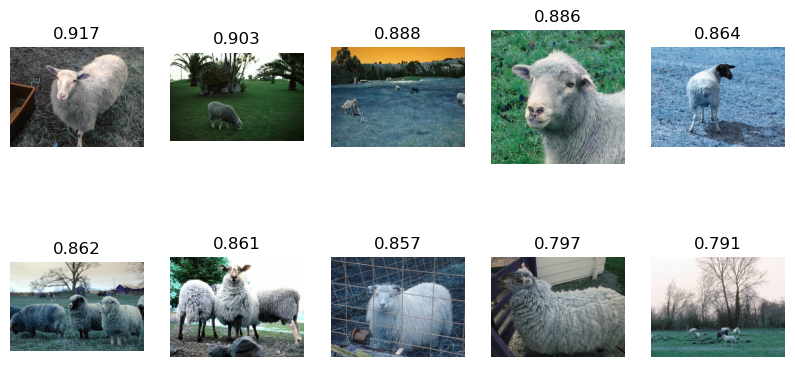

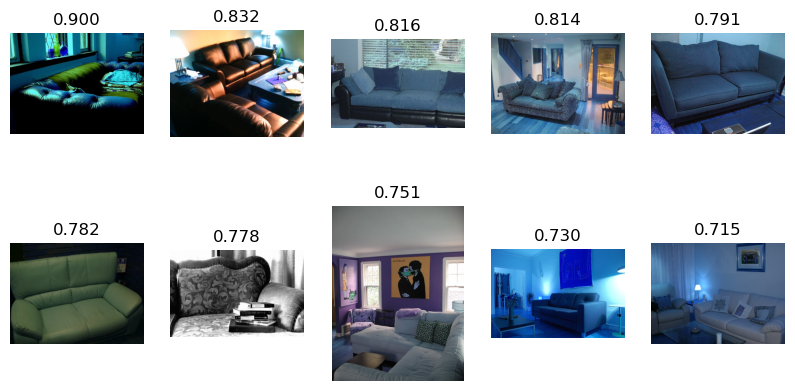

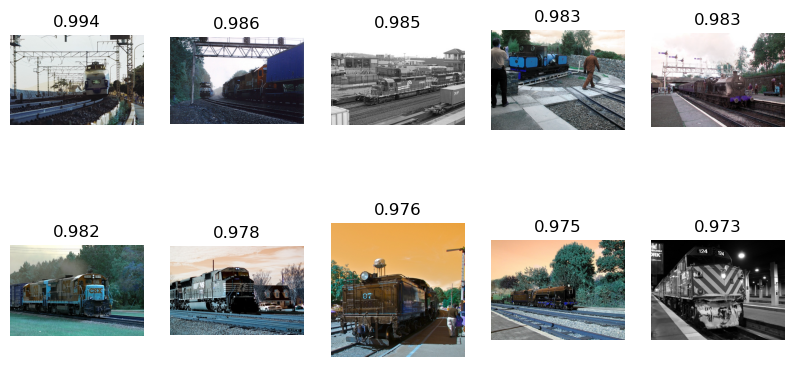

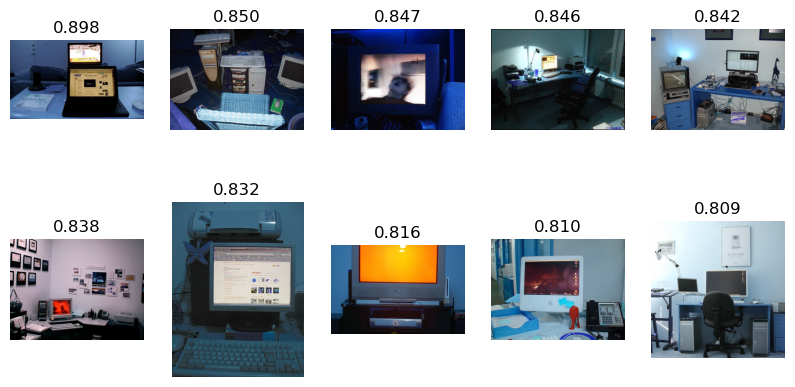

In [16]:

object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

# setting values to rows and column variables
print(len(top_10[0]))

index=0
for class_no in top_10:
    rows = 2
    columns = 5
    fig = plt.figure(figsize=(10,5))
    counter=0
    for class_img in top_10[class_no]:
        
        image=cv2.imread(class_img[1])
        counter=counter+1

        fig.add_subplot(rows, columns, counter)
        plt.imshow(image)
        plt.axis('off')
        plt.title('{:.3f}'.format(class_img[0]))
    index=index+1




Getting mAP

In [49]:
label="VOCdevkit-1/VOCdevkit/VOC2007/ImageSets/Main"
import os
img_Label_Dict=dict() 
temp=[]
for object in object_categories:
    for file in os.listdir(label):
        temp=[]
        name=str(object)+'_val.txt'
        if(file==name):
            file_obj=open(os.path.join(label,f"{file}"),"r")
            file_names=file_obj.read()
            lines=file_names.splitlines()
            for line in lines:
                content=line.split()
                if('-1' not in content):
                    temp.append((content[0],content[1]))
        if(temp):
            img_Label_Dict[object]=temp


print(len(img_Label_Dict['aeroplane']))

  

122


In [18]:
correct_label_per_class=defaultdict(list)
for c in img_Label_Dict:
    for label in img_Label_Dict[c]:
        correct_label_per_class[c].append(int(label[1]))

print(correct_label_per_class['aeroplane'])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
saving predicting probability for each class

In [33]:
counter=0
predicted_probs_per_class=defaultdict(list)
for c in img_Label_Dict:
    for label in img_Label_Dict[c]:
        
        for i,s in enumerate(file_name_list):
            if (str(label[0]) in s):
                predicted_probs_per_class[c].append(prob_list[i][counter])
    counter=counter+1
    
            
              
            
           
                        

                    
       

In [36]:
#print(predicted_probs_per_class['train'])
#print(predicted_probs_per_class['aeroplane'])
from sklearn.metrics import average_precision_score
average_percision_per_class=[]
for c in object_categories:

    average_percision_per_class.append(average_precision_score(correct_label_per_class[c],predicted_probs_per_class[c]))
print(average_percision_per_class)
print(np.mean(average_percision_per_class))
                                

[0.9981145116343237, 0.9555203659310871, 0.9968656747044782, 0.9883375666459223, 0.9407891118491563, 0.9344088654755351, 0.9327378471643002, 0.9966207203274933, 0.7064938591685935, 0.9832640325675012, 0.8397649697631099, 0.9955895415673479, 0.9955729569150489, 0.9961980898374543, 0.9577961788463609, 0.941573172637814, 1.0, 0.6559390257458655, 0.9926687530178993, 0.9650174260622422]
0.9386636334930767
